In [88]:
import pandas as pd
import numpy as np
import joblib
from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.max_seq_items = 2000
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# import python modules
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/Users/tabea/Documents/UrbanMobility/src')
from models_ml_dl import tree_models as tree_models
from visualization import model_evaluation as eval

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Random Forest and Gradient Boosting

### Data Preparation

In [82]:
# hourly data

journey_hourly_16 = pd.read_csv('../data/processed/aggregated_journey_data/agg_journey_data_hourly_2016.csv', parse_dates=['start_date'], index_col=0)
journey_hourly_17 = pd.read_csv('../data/processed/aggregated_journey_data/agg_journey_data_hourly_2017.csv', parse_dates=['start_date'], index_col=0)
journey_hourly_18 = pd.read_csv('../data/processed/aggregated_journey_data/agg_journey_data_hourly_2018.csv', parse_dates=['start_date'], index_col=0)
journey_hourly_19 = pd.read_csv('../data/processed/aggregated_journey_data/agg_journey_data_hourly_2019.csv', parse_dates=['start_date'], index_col=0)

# use 2016, 2017 and 2018 as train data and 2019 as test data
journey_hourly_train = pd.concat([journey_hourly_16, journey_hourly_17, journey_hourly_18])
journey_hourly_test = journey_hourly_19.copy()

# train test split
x_hourly_train, y_hourly_train, x_hourly_test, y_hourly_test = tree_models.train_test_split(journey_hourly_train, journey_hourly_test)
print("Shape x_train and y_train",  x_hourly_train.shape, y_hourly_train.shape)
print("Shape x_test and y_test",  x_hourly_test.shape, y_hourly_test.shape)

Shape x_train and y_train (314748, 105) (314748,)
Shape x_test and y_test (104796, 105) (104796,)


In [74]:
# daily data

journey_daily_16 = pd.read_csv('../data/processed/aggregated_journey_data/agg_journey_data_daily_2016.csv', parse_dates=['start_date'], index_col=0)
journey_daily_17 = pd.read_csv('../data/processed/aggregated_journey_data/agg_journey_data_daily_2017.csv', parse_dates=['start_date'], index_col=0)
journey_daily_18 = pd.read_csv('../data/processed/aggregated_journey_data/agg_journey_data_daily_2018.csv', parse_dates=['start_date'], index_col=0)
journey_daily_19 = pd.read_csv('../data/processed/aggregated_journey_data/agg_journey_data_daily_2019.csv', parse_dates=['start_date'], index_col=0)

# use 2016, 2017 and 2018 as train data and 2019 as test data
journey_daily_train = pd.concat([journey_daily_16, journey_daily_17, journey_daily_18])
journey_daily_test = journey_daily_19.copy()

x_daily_train, y_daily_train, x_daily_test, y_daily_test = tree_models.train_test_split(journey_daily_train, journey_daily_test)

In [83]:
# cols for training

feature_cols_hourly = x_hourly_train.columns.drop('start_date')
feature_cols_daily = x_daily_train.columns.drop(['start_date', 'hour']) 

In [100]:
x_daily_train.columns

Index(['start_date', 'day_of_week', 'hour', 'is_weekend', 'part_of_day', 'month', 'season', 'bank_holiday', 'tempmax', 'tempmin', 'temp', 'feelslike', 'humidity', 'precip', 'windgust', 'windspeed', 'cloudcover', 'visibility', 'uvindex', 'daylight_hours', 'day_of_month', 'day_of_year', 'bike_station_counts', 'bike_docks_counts', 'population_density', 'age_mean', 'age_25_percentile', 'age_75_percentile', 'female_ratio', 'householdsize_1_ratio', 'householdsize_2_ratio', 'householdsize_3-5_ratio', 'householdsize_6+_ratio', 'ethnic_asian_ratio', 'ethnic_african_caribbean_ratio', 'ethnic_mixed_ratio', 'ethnic_white_ratio', 'ethnic_arab_other_ratio', 'religion_no_ratio', 'religion_christian_ratio', 'religion_buddhist_ratio', 'religion_hindu_ratio', 'religion_jewish_ratio', 'religion_muslim_ratio', 'religion_sikh_ratio', 'highes_education_no_ratio', 'highes_education_l1_ratio', 'highes_education_l2_ratio', 'highes_education_apprenticeship_ratio', 'highes_education_l3_ratio',
       'highes_edu

In [84]:
# bororughs for visualisation

boroughs = ['Westminster', 'Tower Hamlets', 'Kensington and Chelsea', 'Camden', 'Hammersmith and Fulham', 'Lambeth', 'Wandsworth', 'Southwark', 
            'Hackney', 'City of London', 'Islington', 'Newham']

### 1: Random Forest Model and Hyperparameter Tuning

In [6]:
# define pramater ranges for random search
param_grid = {
    'n_estimators': randint(100, 1000),  # Number of trees in the random forest
    'max_depth': randint(5, 20),  # Maximum depth of the tree
    'min_samples_split': randint(2, 10),  # Minimum number of samples required to split a node
    'min_samples_leaf': randint(1, 10)  # Minimum number of samples required at each leaf node
}

# run random search
rf = RandomForestRegressor(random_state=42)
random_search = tree_models.hyper_param_tuning(rf, x_hourly_train, y_hourly_train, 10, 3, param_grid)

# print or log all tried parameters and their scores
print(pd.DataFrame(random_search.cv_results_)[['params', 'mean_test_score', 'rank_test_score']])

# predict on the test set using the best model
rf = random_search.best_estimator_

                                              params  mean_test_score  rank_test_score
0  {'max_depth': 11, 'min_samples_leaf': 4, 'min_...         0.830273                9
1  {'max_depth': 15, 'min_samples_leaf': 8, 'min_...         0.860645                4
2  {'max_depth': 11, 'min_samples_leaf': 3, 'min_...         0.830731                8
3  {'max_depth': 15, 'min_samples_leaf': 8, 'min_...         0.860879                3
4  {'max_depth': 12, 'min_samples_leaf': 8, 'min_...         0.840575                7
5  {'max_depth': 9, 'min_samples_leaf': 2, 'min_s...         0.786472               10
6  {'max_depth': 18, 'min_samples_leaf': 6, 'min_...         0.873432                1
7  {'max_depth': 16, 'min_samples_leaf': 5, 'min_...         0.870832                2
8  {'max_depth': 14, 'min_samples_leaf': 6, 'min_...         0.859290                5
9  {'max_depth': 13, 'min_samples_leaf': 1, 'min_...         0.856927                6


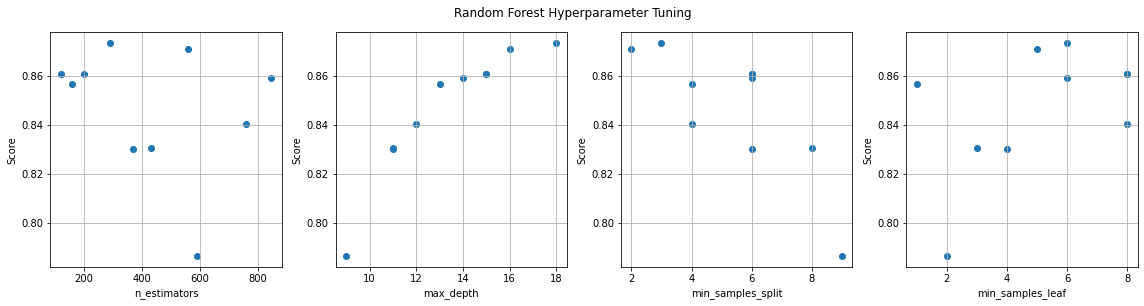

In [36]:
# visualize random search results
features = ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf']
eval.visualize_random_search(random_search, features, title='Random Forest Hyperparameter Tuning')

In [85]:
# hyperparamters based on the hyperparameter tuning
max_depth=18
min_samples_leaf=6
min_samples_split=3
n_estimators=291

# create and save model
rf = RandomForestRegressor(random_state=42, max_depth=max_depth, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, n_estimators=n_estimators)

### Model 1A: Random Forest, hourly aggregated, hours without 0 demand

RMSE: 52.629349135049885;
MAE: 26.084786055217304;
R2 Score: 0.8561147834124019

Interpretation: Slightly lower scores than the one with filled 0 demand rows, no obvious differences on evaluation vis

### Model 1B: Random Forest, hourly aggregated

In [186]:
# fit hourly data
feature_cols_hourly = x_hourly_train.columns.drop('start_date') # remove start_date for training
rf_hourly = rf.fit(x_hourly_train[feature_cols_hourly], y_hourly_train)
joblib.dump(rf_hourly, '../models/random_forest_hourly.pkl')

['../models/random_forest_hourly.pkl']

In [187]:
# predict on the test set using the best model
y_pred_1b = rf_hourly.predict(x_hourly_test[feature_cols_hourly])

In [188]:
# evaluation metrics
rmse, mae, r2 = eval.evaluation_metrics(y_hourly_test, y_pred_1b)

print('RMSE:', rmse)
print('MAE:', mae)
print('R2 Score:', r2)

RMSE: 50.31905526150429
MAE: 24.60123901987008
R2 Score: 0.8666784181790499


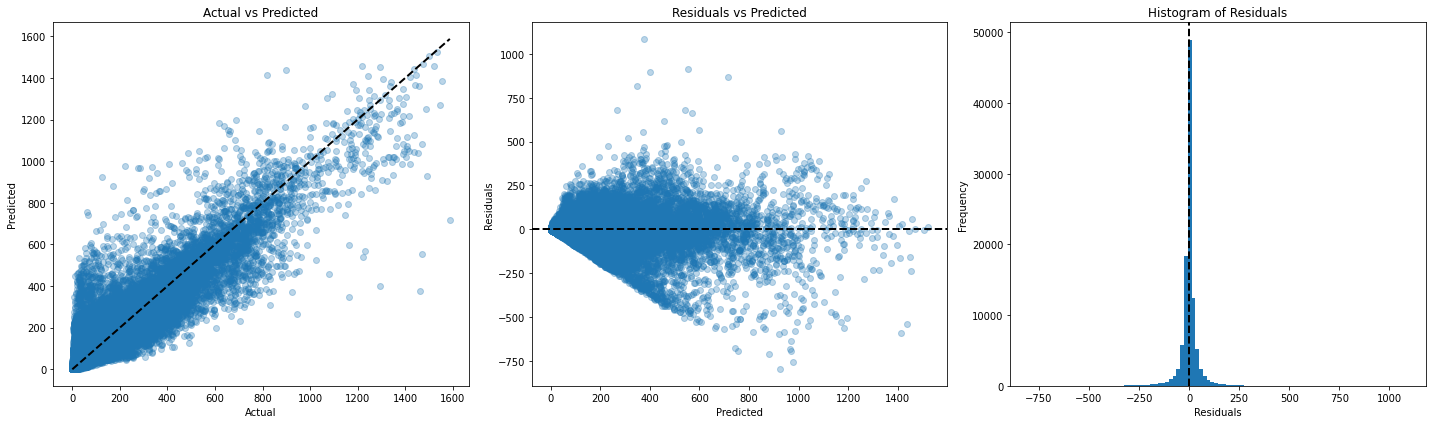

In [189]:
# evaluation visualisation
eval.evaluation_vis(y_hourly_test, y_pred_1b)

In [ ]:
# visualisation: pred vs actual
eval.evaluation_actual_vs_predicted_hourly(y_hourly_test, y_pred_1b, journey_hourly_test, 'All_Boroughs', 'model_random_forest_1b')

In [ ]:
for borough in boroughs:
    eval.evaluation_actual_vs_predicted_hourly(y_hourly_test, y_pred_1b, journey_hourly_test, borough, 'model_random_forest_1b')

In [192]:
# investigate elements with highest errors
df_errors = eval.get_enornous_entrie(y_hourly_test, y_pred_1b, x_hourly_test)
df_errors.head(6)

# interpretation: bank holiday, december, westminster

Actual   Predicted        Error  day_of_week  hour  month  bank_holiday  start_borough_Westminster
103271  1464.0  377.694431  1086.305569          2.0  16.0   12.0           1.0                          1
103247  1470.0  555.719469   914.280531          2.0  14.0   12.0           1.0                          1
103235  1296.0  401.254328   894.745672          2.0  13.0   12.0           1.0                          1
103259  1588.0  716.455744   871.544256          2.0  15.0   12.0           1.0                          1
103223  1162.0  346.237000   815.763000          2.0  12.0   12.0           1.0                          1
98963    126.0  924.589489   798.589489          1.0  17.0   12.0           0.0                          1

In [53]:
# feature importance
print(eval.get_feature_importance(rf_hourly, x_hourly_train[feature_cols_hourly]).to_string())

                                       Feature  Importance
1                                         hour     0.42856
7                                 day_of_month     0.07207
19                         bike_station_counts     0.04878
20                           bike_docks_counts     0.04843
0                                  day_of_week     0.02788
37                     religion_buddhist_ratio     0.02768
10                                   feelslike     0.02704
9                                         temp     0.02631
34                     ethnic_arab_other_ratio     0.02618
56                         crime_offences_rate     0.02612
74               residence_lengh_uk_born_ratio     0.02359
3                                  part_of_day     0.02340
103                  start_borough_Westminster     0.02146
48                              health_1_ratio     0.02133
2                                   is_weekend     0.02089
8                                  day_of_year     0.016

### Model 1C: Random Forest, daily aggregated

In [21]:
# fit daily data
rf_daily = rf.fit(x_daily_train[feature_cols_daily], y_daily_train)
joblib.dump(rf_daily, '../models/random_forest_daily.pkl')

['../models/random_forest_daily.pkl']

In [89]:
# predict on the test set using the best model
y_pred_1c = rf_daily.predict(x_daily_test[feature_cols_daily])

In [90]:
# evaluation metrics
rmse, mae, r2 = eval.evaluation_metrics(y_daily_test, y_pred_1c)

print('RMSE:', rmse)
print('MAE:', mae)
print('R2 Score:', r2)

RMSE: 555.3812115839123
MAE: 345.8483134955886
R2 Score: 0.9063528469404001


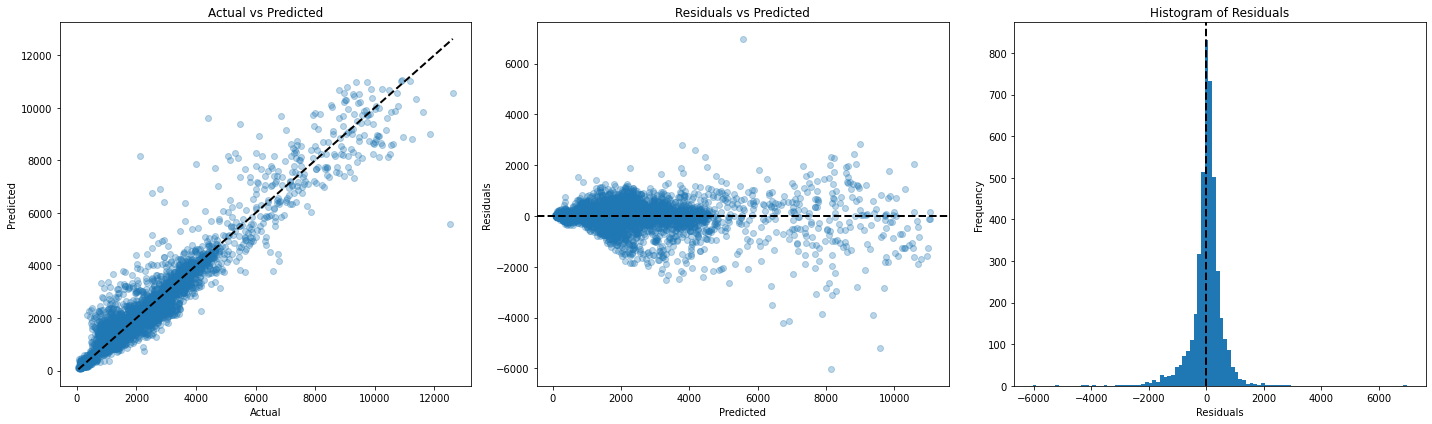

In [91]:
# evaluation visualisation
eval.evaluation_vis(y_daily_test, y_pred_1c)

In [25]:
# investigate elements with highest errors
df_errors = eval.get_enornous_entrie(y_daily_test, y_pred_1c, x_daily_test)
df_errors.head(6)

Actual    Predicted        Error  day_of_week  hour  month  bank_holiday  start_borough_Westminster
4307   12538  5570.268149  6967.731851            2     0   12.0           1.0                          1
4127    2113  8148.679754  6035.679754            1     0   12.0           0.0                          1
2603    4415  9594.663238  5179.663238            0     0    8.0           1.0                          1
3047    2520  6741.178342  4221.178342            2     0    9.0           0.0                          1
3347    2778  6925.613327  4147.613327            6     0   10.0           0.0                          1
2243    5490  9374.815734  3884.815734            5     0    7.0           0.0                          1

In [92]:
# feature importance
print(eval.get_feature_importance(rf_daily, x_daily_train[feature_cols_daily]).to_string())

                                       Feature  Importance
21                           bike_docks_counts     0.12879
20                         bike_station_counts     0.12185
38                     religion_buddhist_ratio     0.08779
104                  start_borough_Westminster     0.08416
35                     ethnic_arab_other_ratio     0.07846
49                              health_1_ratio     0.07488
18                                day_of_month     0.07269
6                                      tempmax     0.07248
75               residence_lengh_uk_born_ratio     0.06375
57                         crime_offences_rate     0.06114
11                                      precip     0.01455
10                                    humidity     0.01080
0                                  day_of_week     0.00960
1                                   is_weekend     0.00809
19                                 day_of_year     0.00800
16                                     uvindex     0.006

### Model 1D: Random Forest, hourly aggreagted, log-transformed

In [29]:
# Apply a log transformation to the target
y_hourly_train_log = np.log1p(y_hourly_train)

# Fit the model on the transformed target
rf_hourly_log_transformed = rf.fit(x_hourly_train[feature_cols_hourly], y_hourly_train_log)
joblib.dump(rf_hourly_log_transformed, '../models/random_forest_hourly_log_transformed.pkl')

# Predict on the test set
y_pred_1d = rf_hourly_log_transformed.predict(x_hourly_test[feature_cols_hourly])

In [30]:
# Apply the inverse log transformation -> original scale
y_pred_1d_log_inverse = np.expm1(y_pred_1d)

# evaluation metrics
rmse, mae, r2 = eval.evaluation_metrics(y_hourly_test, y_pred_1d_log_inverse)

print('RMSE:', rmse)
print('MAE:', mae)
print('R2 Score:', r2)

RMSE: 54.857047474979744
MAE: 25.900699220312514
R2 Score: 0.8415470391034063


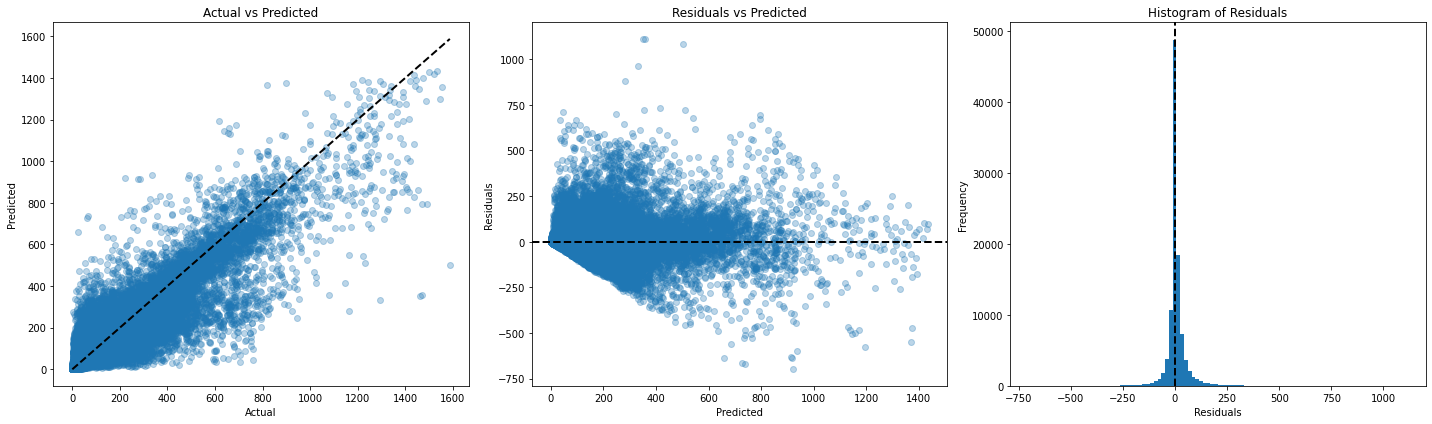

In [31]:
# evaluation visualisation
eval.evaluation_vis(y_hourly_test, y_pred_1d_log_inverse)

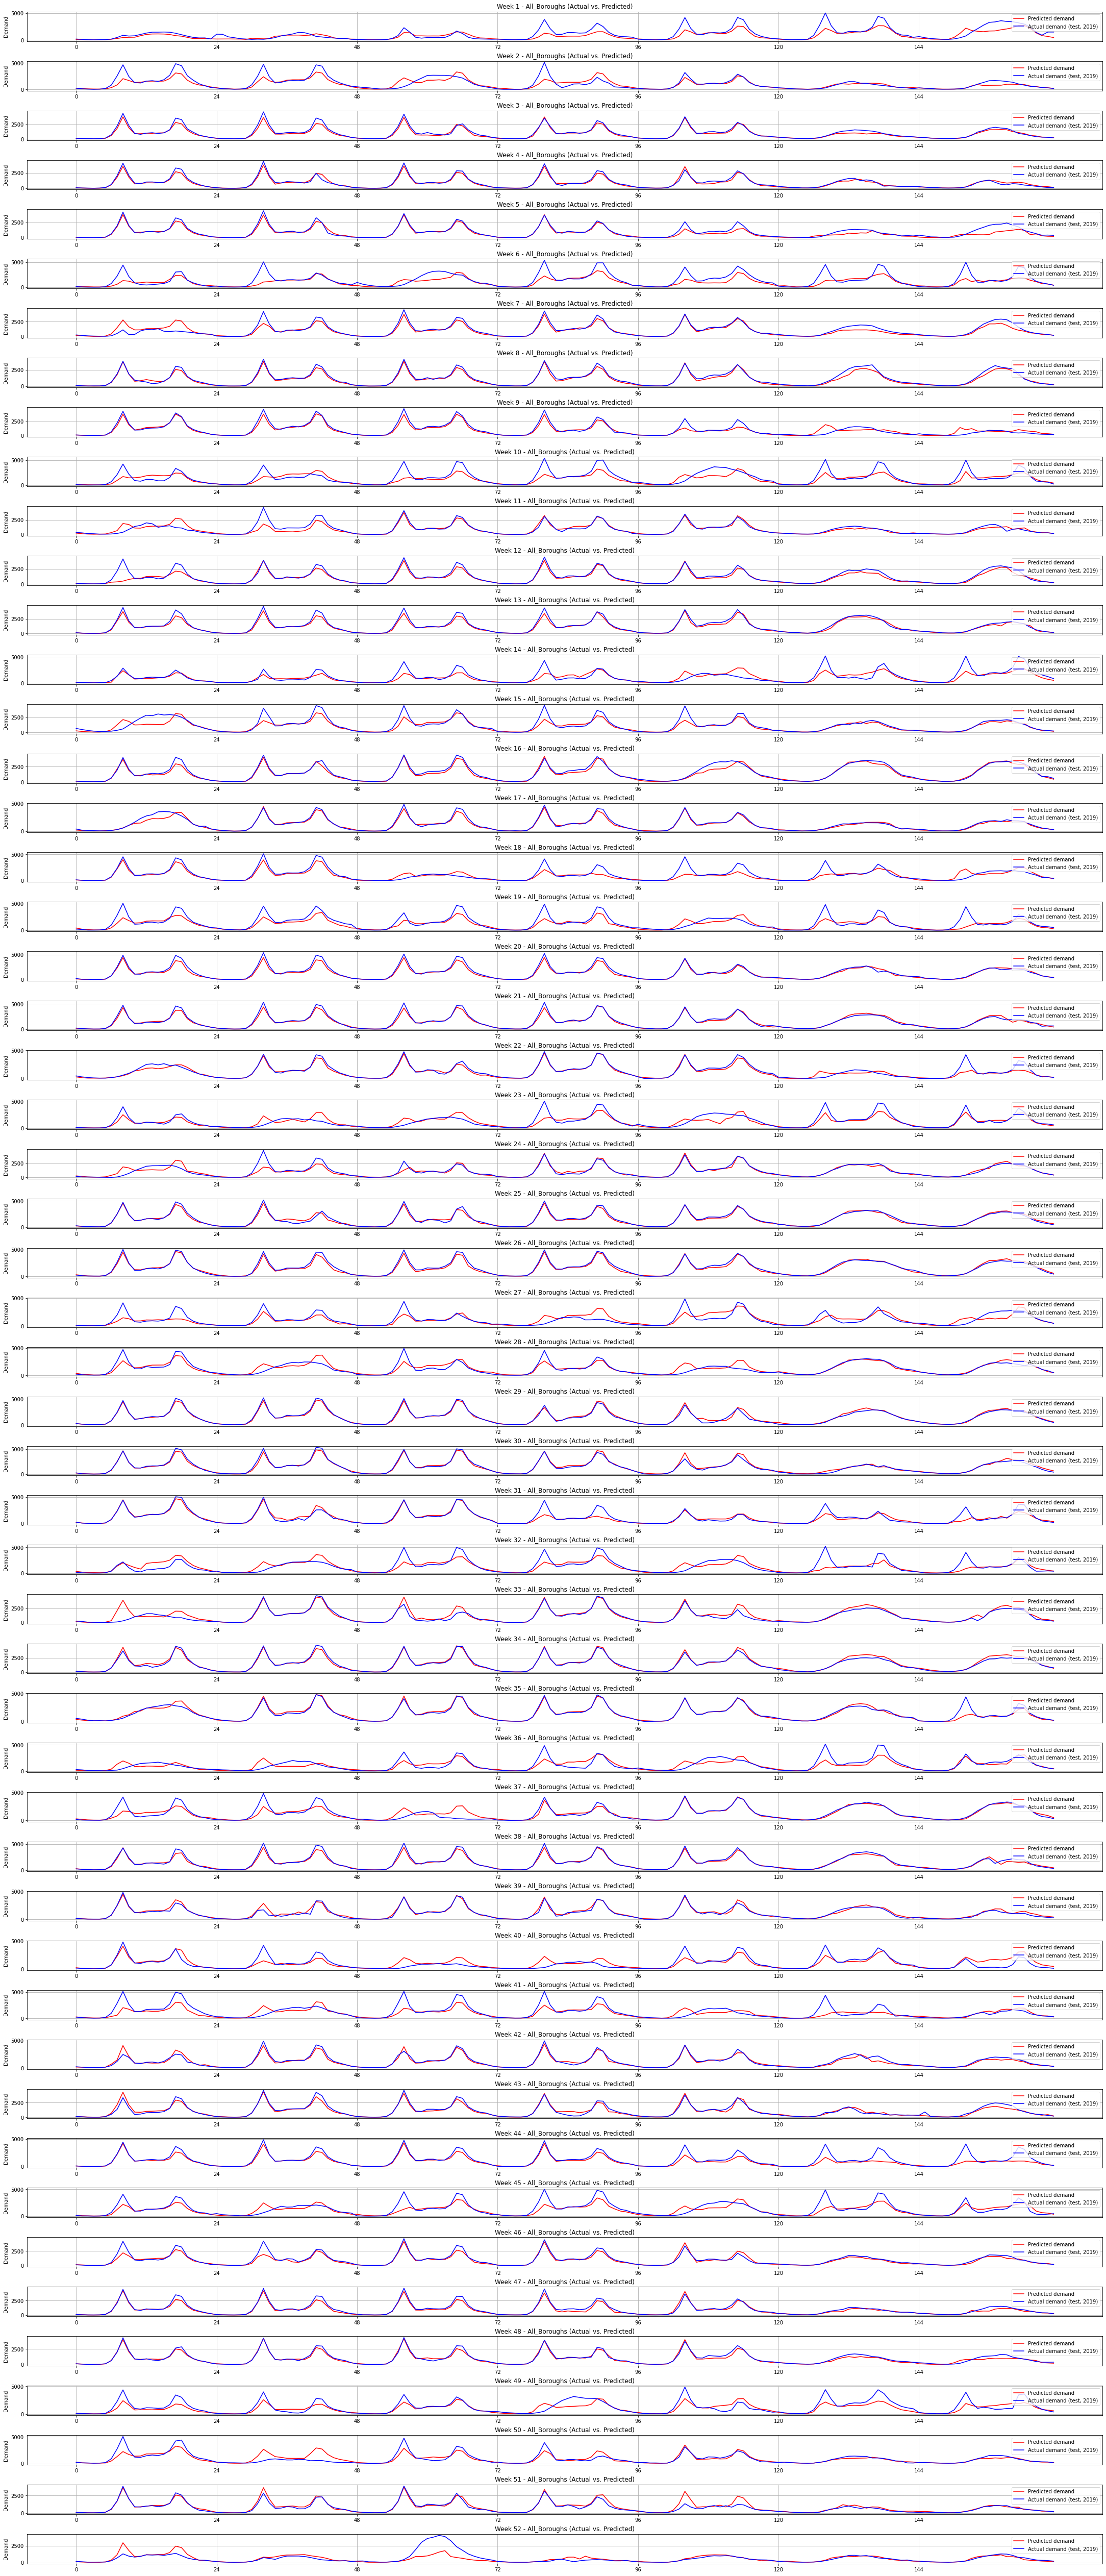

In [32]:
# visualisation: pred vs actual
eval.evaluation_actual_vs_predicted_hourly(y_hourly_test, y_pred_1d_log_inverse, journey_hourly_test, 'All_Boroughs', 'model_random_forest_1d')

In [ ]:
# visualisation: pred vs actual per borough
for borough in boroughs:
    eval.evaluation_actual_vs_predicted_hourly(y_hourly_test, y_pred_1d_log_inverse, journey_hourly_test, borough, 'model_random_forest_1d')

In [34]:
# investigate elements with highest errors
df_errors = eval.get_enornous_entrie(y_hourly_test, y_pred_1d_log_inverse, x_hourly_test)
df_errors.head(6)

# interpretation: all of them are from westminster, bank holidays and in December

Actual   Predicted        Error  day_of_week  hour  month  bank_holiday  start_borough_Westminster
103271  1464.0  352.580685  1111.419315          2.0  16.0   12.0           1.0                          1
103247  1470.0  359.203341  1110.796659          2.0  14.0   12.0           1.0                          1
103259  1588.0  503.173870  1084.826130          2.0  15.0   12.0           1.0                          1
103235  1296.0  332.226976   963.773024          2.0  13.0   12.0           1.0                          1
103223  1162.0  281.978139   880.021861          2.0  12.0   12.0           1.0                          1
11735   1146.0  413.964057   732.035943          6.0  17.0    2.0           0.0                          1

In [48]:
# feature importance
print(eval.get_feature_importance(rf_hourly_log_transformed, x_hourly_train[feature_cols_hourly]).to_string())

                                       Feature  Importance
1                                         hour    0.428500
7                                 day_of_month    0.072088
19                         bike_station_counts    0.050691
20                           bike_docks_counts    0.047549
10                                   feelslike    0.028478
37                     religion_buddhist_ratio    0.027619
0                                  day_of_week    0.026712
56                         crime_offences_rate    0.026217
34                     ethnic_arab_other_ratio    0.026169
9                                         temp    0.024958
74               residence_lengh_uk_born_ratio    0.023831
3                                  part_of_day    0.023258
2                                   is_weekend    0.022203
103                  start_borough_Westminster    0.021397
48                              health_1_ratio    0.021344
8                                  day_of_year    0.0163

### Model 1E: Random Forest, hourly aggregated, standardised demand

In [35]:
# test and train split with standardisation by dock station
x_hourly_stand_train, y_hourly_stand_train, x_hourly_stand_test, y_hourly_stand_test = tree_models.train_test_split(journey_hourly_train, journey_hourly_test, standardise=True)

# fit hourly standardized data
rf_hourly_standardised = rf.fit(x_hourly_stand_train[feature_cols_hourly], y_hourly_stand_train)
joblib.dump(rf_hourly_standardised, '../models/random_forest_hourly_standardised.pkl')

# predict standardised demand
y_pred_1e = rf_hourly_standardised.predict(x_hourly_stand_test[feature_cols_hourly])

In [36]:
# evaluation metrics
rmse_stand, mae_stand, r2_stand = eval.evaluation_metrics(y_hourly_stand_test, y_pred_1e)

print('RMSE:', rmse_stand)
print('MAE:', mae_stand)
print('R2 Score:', r2_stand)

RMSE: 0.03135122542689506
MAE: 0.01583376364677373
R2 Score: 0.7985680110370641


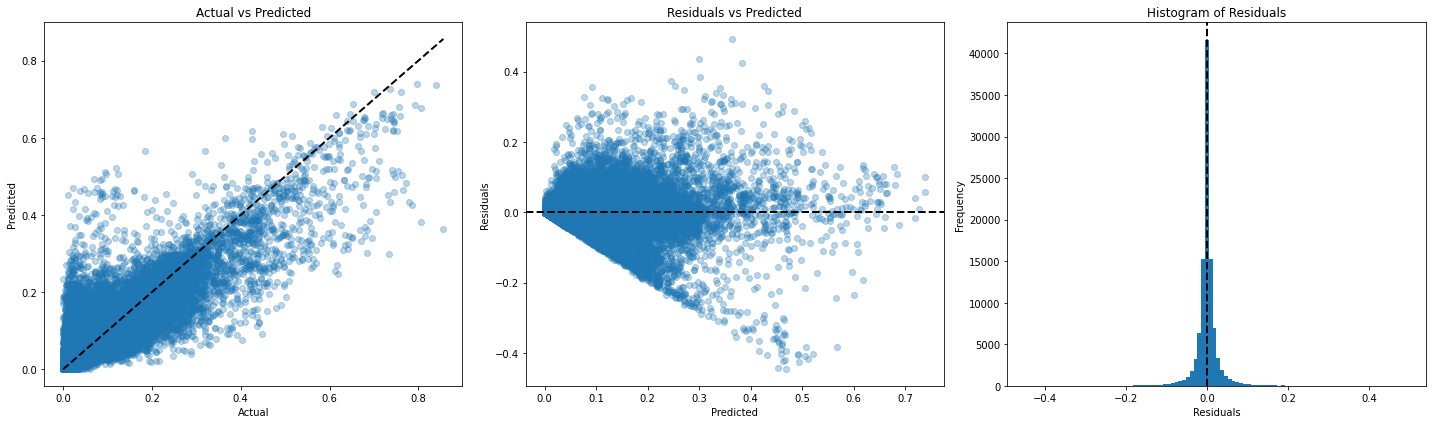

In [37]:
# evaluation visualisation
eval.evaluation_vis(y_hourly_stand_test, y_pred_1e)

In [93]:
print(eval.get_feature_importance(rf_hourly_standardised, x_hourly_train[feature_cols_hourly]).to_string())

                                       Feature  Importance
1                                         hour     0.42850
7                                 day_of_month     0.07209
19                         bike_station_counts     0.05069
20                           bike_docks_counts     0.04755
10                                   feelslike     0.02848
37                     religion_buddhist_ratio     0.02762
0                                  day_of_week     0.02671
56                         crime_offences_rate     0.02622
34                     ethnic_arab_other_ratio     0.02617
9                                         temp     0.02496
74               residence_lengh_uk_born_ratio     0.02383
3                                  part_of_day     0.02326
2                                   is_weekend     0.02220
103                  start_borough_Westminster     0.02140
48                              health_1_ratio     0.02134
8                                  day_of_year     0.016

### Model 1F: Random Forest, hourly aggregated, Moving Averages and Lag Features

In [86]:
# add ma and lag features
journey_hourly_train_ma_lag, journey_hourly_test_ma_lag = tree_models.add_ma_lag_features(journey_hourly_train, journey_hourly_test)

# train and test split with added lag and ma features
x_hourly_lag_train, y_hourly_lag_train, x_hourly_lag_test, y_hourly_lag_test = tree_models.train_test_split(journey_hourly_train_ma_lag, journey_hourly_test_ma_lag)
feature_cols_hourly_lag_ma = x_hourly_lag_train.columns.drop(['start_date']) 

# fit hourly lag engineered data
rf_hourly_lag = rf.fit(x_hourly_lag_train[feature_cols_hourly_lag_ma], y_hourly_lag_train)
joblib.dump(rf_hourly_lag, '../models/random_forest_hourly_lag_ma.pkl')

# predict lag engineered demand
y_pred_1f = rf_hourly_lag.predict(x_hourly_lag_test[feature_cols_hourly_lag_ma])

In [90]:
# evaluation metrics
rmse, mae, r2 = eval.evaluation_metrics(y_hourly_lag_test, y_pred_1f)

print('RMSE:', rmse)
print('MAE:', mae)
print('R2 Score:', r2)

RMSE: 15.837255833588562
MAE: 8.36894791960758
R2 Score: 0.9867932679931701


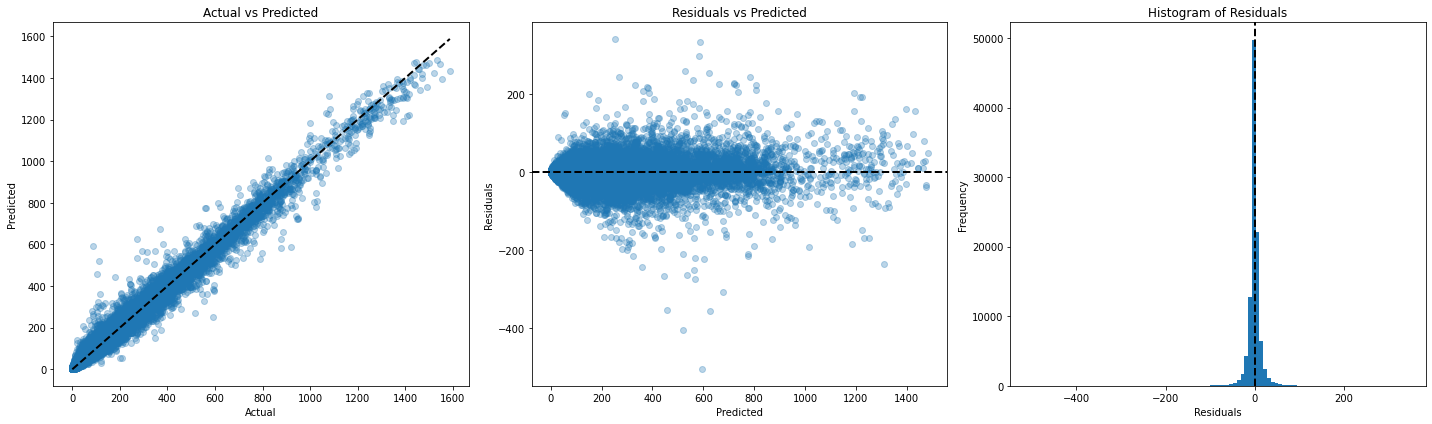

In [91]:
# evaluation visualisation
eval.evaluation_vis(y_hourly_lag_test, y_pred_1f)

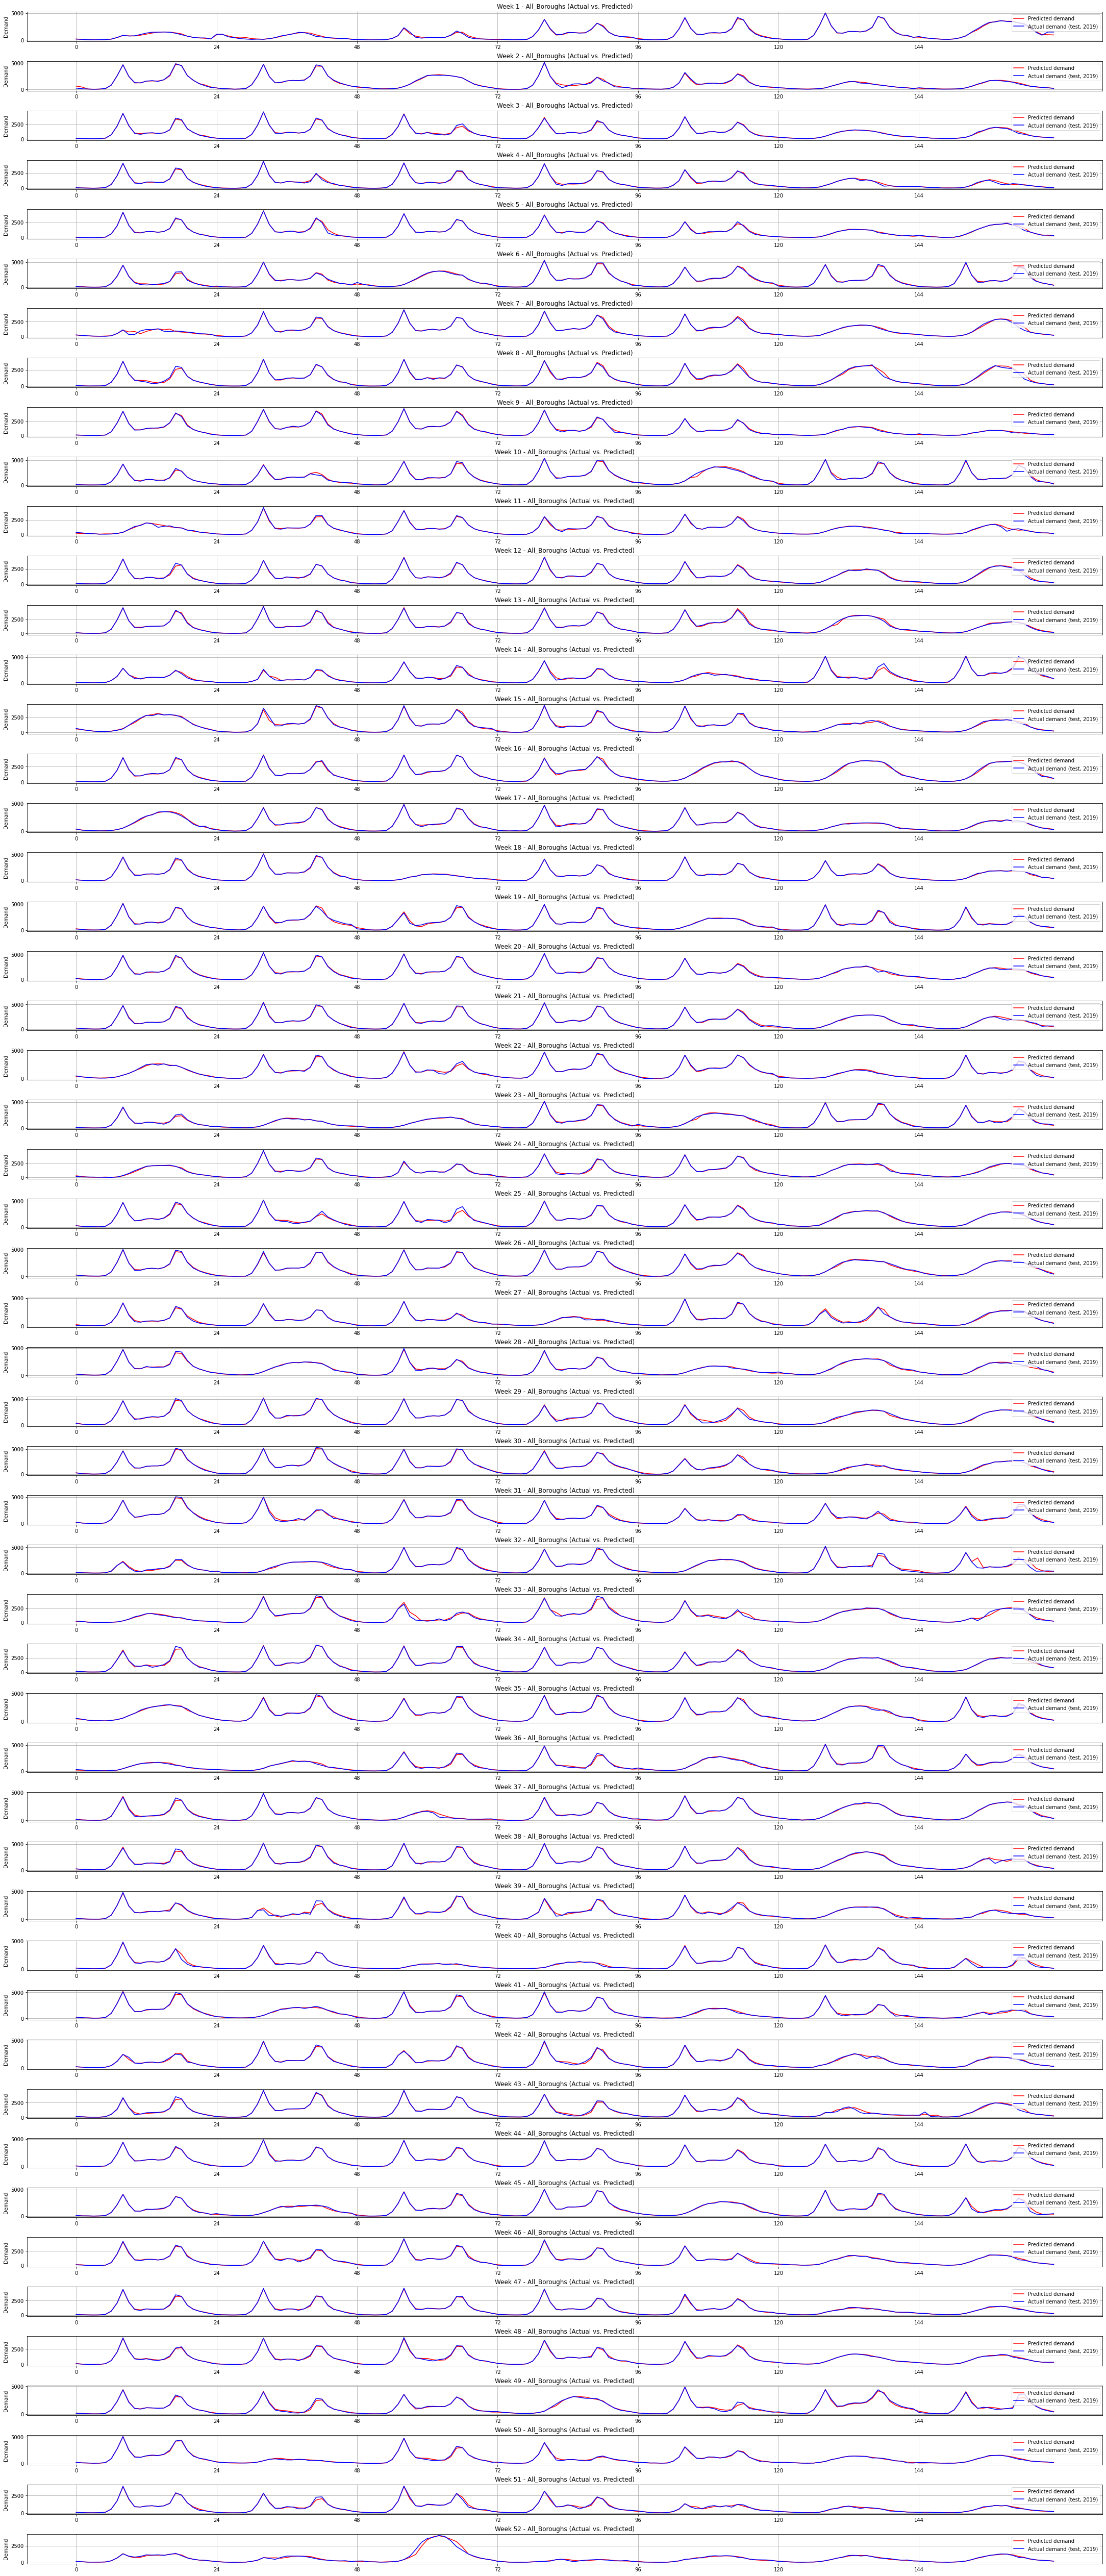

In [92]:
# visualisation: pred vs actual
eval.evaluation_actual_vs_predicted_hourly(y_hourly_lag_test, y_pred_1f, journey_hourly_test, 'All_Boroughs', 'model_random_forest_1f')

In [ ]:
# visualisation: pred vs actual per borough

for borough in boroughs:
    eval.evaluation_actual_vs_predicted_hourly(y_hourly_lag_test, y_pred_1f, journey_hourly_test, borough, 'model_random_forest_1f')

In [94]:
# investigate elements with highest errors
df_errors = eval.get_enornous_entrie(y_hourly_lag_test, y_pred_1f, x_hourly_test)
df_errors.head(6)

Actual  Predicted     Error  day_of_week     hour   month  bank_holiday  start_borough_Westminster
64029  89.00000  594.88374 505.88374      6.00000 10.00000 8.00000       0.00000                          0
64027 113.00000  518.39162 405.39162      6.00000 10.00000 8.00000       0.00000                          0
19424 271.00000  626.66043 355.66043      5.00000 10.00000 3.00000       0.00000                          0
64133 103.00000  457.81237 354.81237      6.00000 19.00000 8.00000       0.00000                          0
19137 593.00000  251.72710 341.27290      4.00000 10.00000 3.00000       0.00000                          0
22094 919.00000  585.45316 333.54684      0.00000 17.00000 3.00000       1.00000                          0

In [95]:
print(eval.get_feature_importance(rf_hourly_lag, x_hourly_lag_train[feature_cols_hourly_lag_ma]).to_string())

                                       Feature  Importance
104                               demand_ma_3h     0.78011
109                             demand_lag_24h     0.06327
3                                  part_of_day     0.04967
1                                         hour     0.04733
110                              demand_lag_1w     0.01665
105                               demand_ma_8h     0.01290
107                              demand_lag_1h     0.01145
108                              demand_lag_8h     0.00778
106                              demand_ma_24h     0.00125
35                           religion_no_ratio     0.00046
7                                 day_of_month     0.00041
20                           bike_docks_counts     0.00040
19                         bike_station_counts     0.00036
71                  accommodation_mobile_ratio     0.00034
12                                    humidity     0.00032
64            distance_work_no_fix_place_ratio     0.000

### 2: Gradient Boosting Model and Hyperparameter Tuning

In [60]:
# define pramater ranges for random search

param_grid = {
        'n_estimators': randint(100, 1000),  # Number of boosting stages to perform
        'max_depth': randint(3, 10),  # Maximum depth of the individual regression estimators
        'min_samples_split': randint(2, 10),  # Minimum number of samples required to split a node
        'min_samples_leaf': randint(1, 10),  # Minimum number of samples required at each leaf node
        'learning_rate': [0.01, 0.05, 0.1, 0.2]  # Learning rate
    }

# initialize the Gradient Boosting Regressor
gb = GradientBoostingRegressor(random_state=42)
random_search = tree_models.hyper_param_tuning(gb, x_hourly_train[feature_cols_hourly], y_hourly_train, 10, 3, param_grid)

# print or log all tried parameters and their scores
print(pd.DataFrame(random_search.cv_results_)[['params', 'mean_test_score', 'rank_test_score']])

gb = random_search.best_estimator_

                                              params  mean_test_score  rank_test_score
0  {'learning_rate': 0.1, 'max_depth': 6, 'min_sa...          0.82441                6
1  {'learning_rate': 0.1, 'max_depth': 4, 'min_sa...          0.79315                9
2  {'learning_rate': 0.1, 'max_depth': 7, 'min_sa...          0.82512                5
3  {'learning_rate': 0.1, 'max_depth': 8, 'min_sa...          0.83036                3
4  {'learning_rate': 0.2, 'max_depth': 8, 'min_sa...          0.82369                7
5  {'learning_rate': 0.2, 'max_depth': 7, 'min_sa...          0.81651                8
6  {'learning_rate': 0.05, 'max_depth': 7, 'min_s...          0.83227                1
7  {'learning_rate': 0.1, 'max_depth': 9, 'min_sa...          0.83072                2
8  {'learning_rate': 0.2, 'max_depth': 3, 'min_sa...          0.77185               10
9  {'learning_rate': 0.1, 'max_depth': 7, 'min_sa...          0.83033                4


In [61]:
print(gb)

GradientBoostingRegressor(learning_rate=0.05, max_depth=7, min_samples_leaf=9,
                          n_estimators=574, random_state=42)


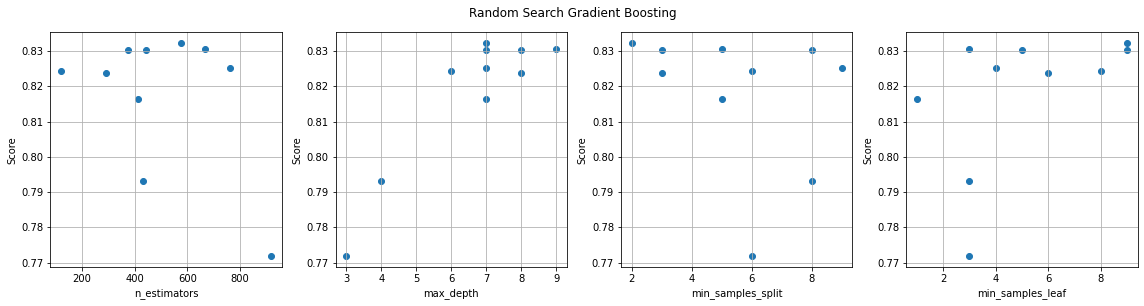

In [62]:
# visualize random search results
features = ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf']
eval.visualize_random_search(random_search, features, 'Random Search Gradient Boosting')

In [63]:
# hyperparamters based on the hyperparameter tuning
learning_rate = gb.learning_rate
max_depth = gb.max_depth
min_samples_leaf = gb.min_samples_leaf
min_samples_split = gb.min_samples_split
n_estimators = gb.n_estimators

# create model
gb = GradientBoostingRegressor(random_state=42, learning_rate=learning_rate, max_depth=max_depth, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, n_estimators=n_estimators)

### Model 2A: Gradient Boosting

In [64]:
# fit and predict
gb_hourly = gb.fit(x_hourly_train[feature_cols_hourly], y_hourly_train)
joblib.dump(gb_hourly, '../models/gradient_boosting_hourly.pkl')

y_pred_2a = gb_hourly.predict(x_hourly_test[feature_cols_hourly])

In [65]:
# evaluation metrics
rmse, mae, r2 = eval.evaluation_metrics(y_hourly_test, y_pred_2a)

print('RMSE:', rmse)
print('MAE:', mae)
print('R2 Score:', r2)

RMSE: 50.73496194684668
MAE: 26.388116351048502
R2 Score: 0.8644653999843708


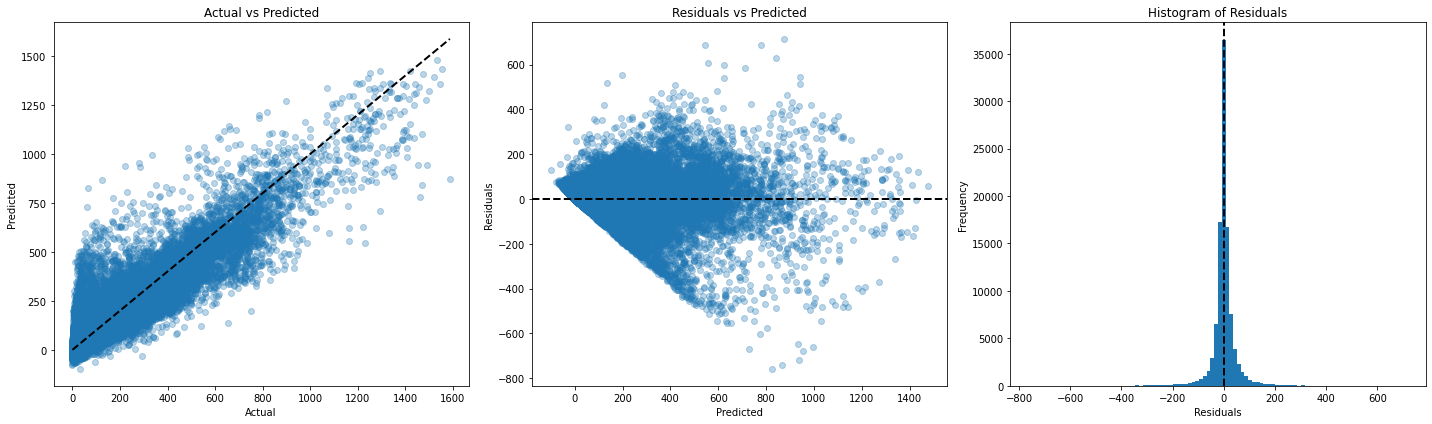

In [66]:
# evaluation visualisation
eval.evaluation_vis(y_hourly_test, y_pred_2a)

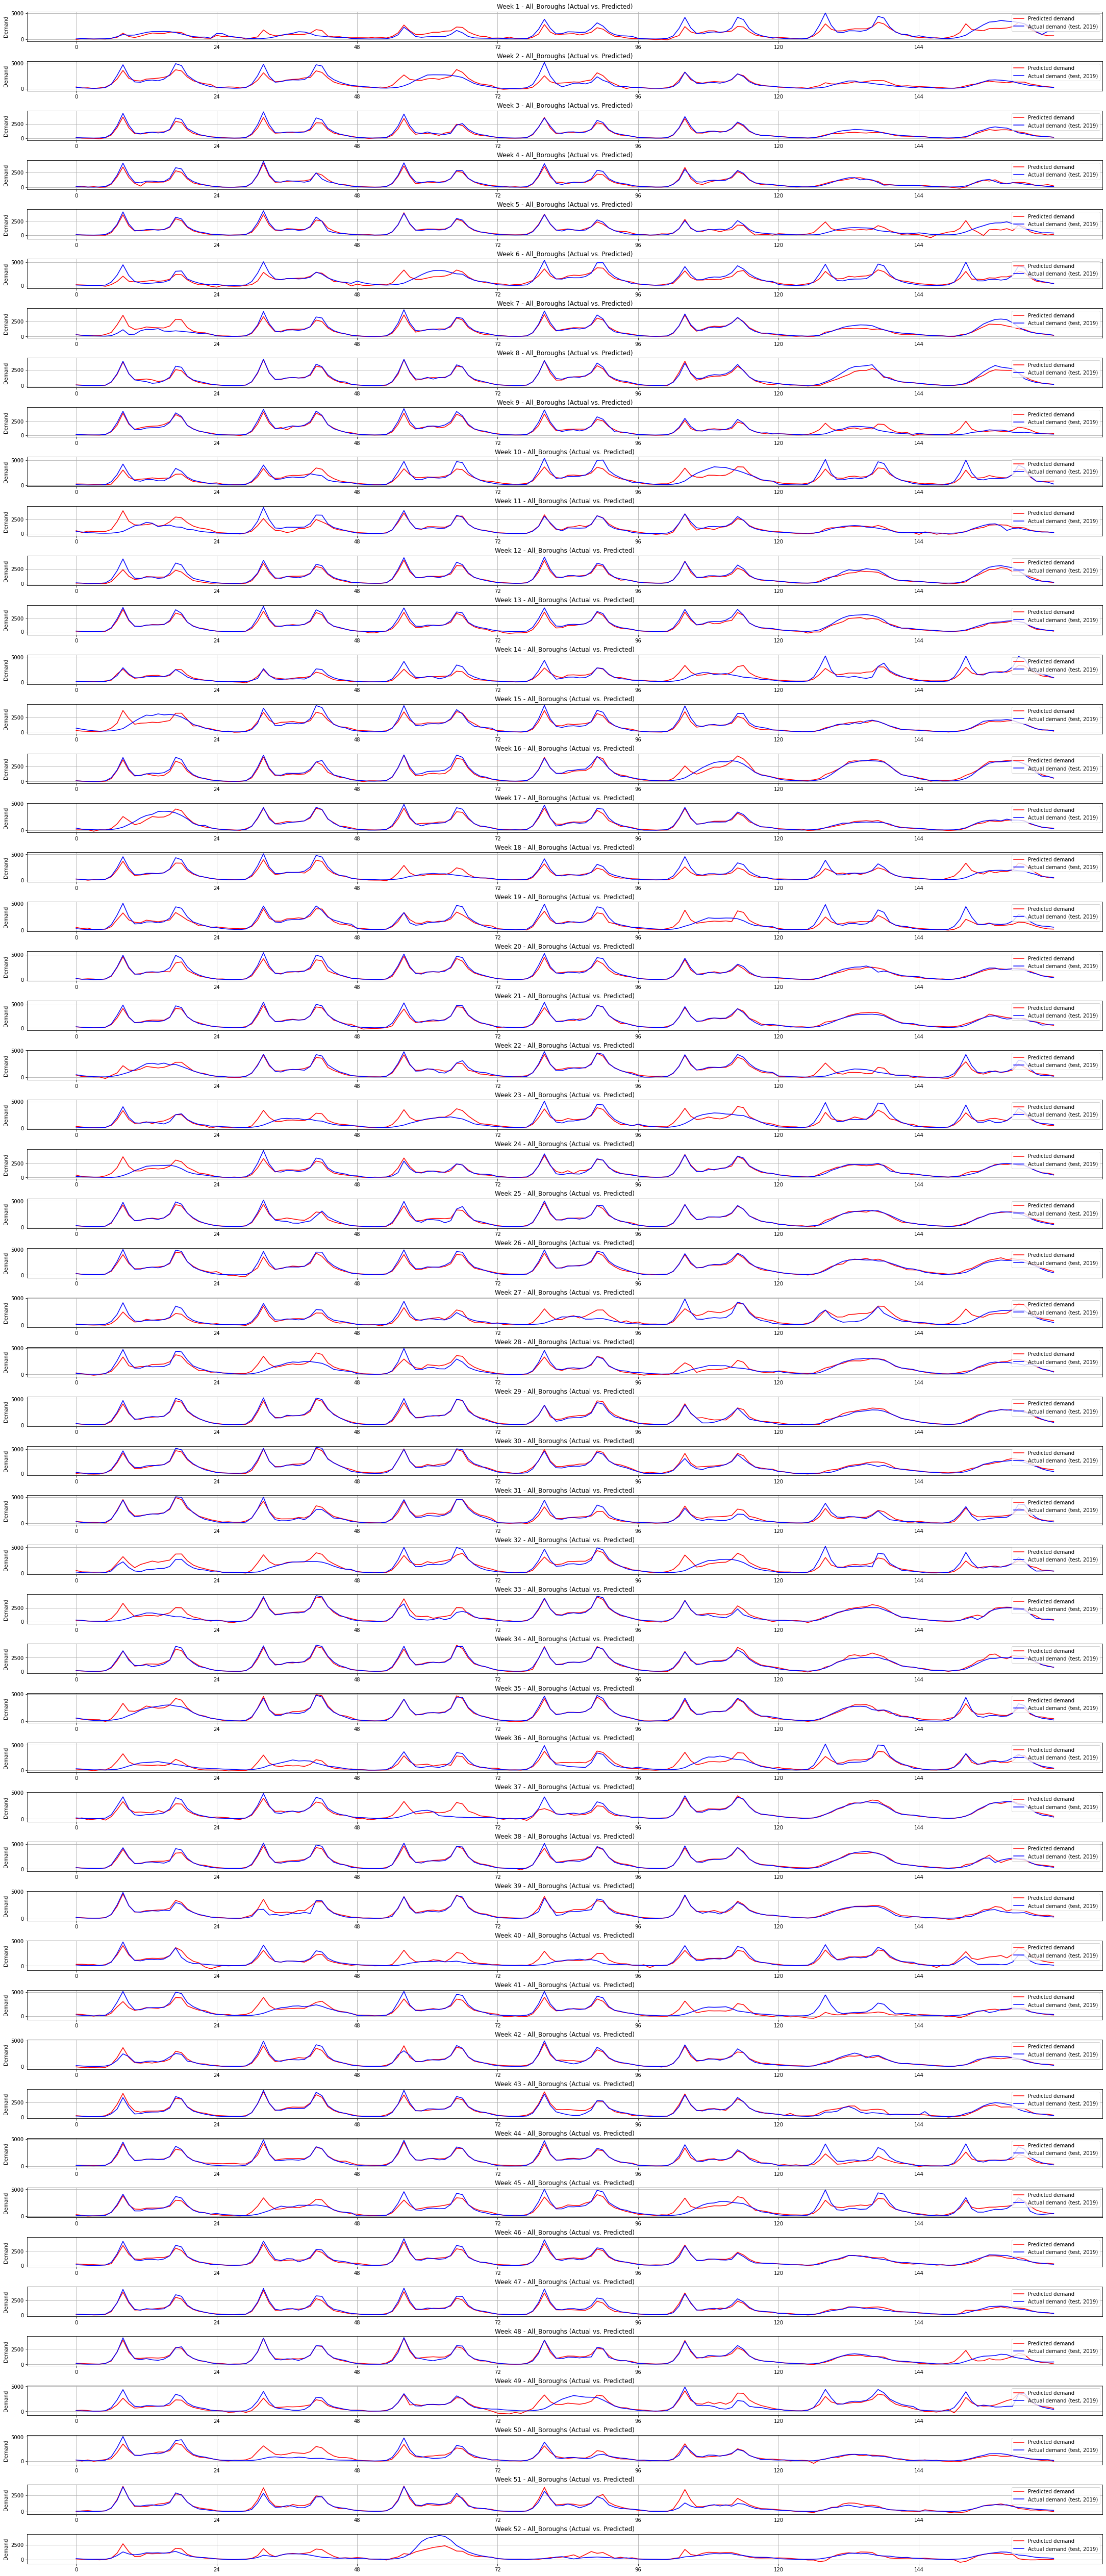

In [67]:
# visualisation: pred vs actual
eval.evaluation_actual_vs_predicted_hourly(y_hourly_test, y_pred_2a, journey_hourly_test, 'All_Boroughs', 'model_random_forest_1b')

In [ ]:
for borough in boroughs:
    eval.evaluation_actual_vs_predicted_hourly(y_hourly_test, y_pred_2a, journey_hourly_test, borough, 'model_gradient_boosting_2a')

In [69]:
# investigate elements with highest errors
df_errors = eval.get_enornous_entrie(y_hourly_test, y_pred_2a, x_hourly_test)
df_errors.head(6)

Actual  Predicted     Error  day_of_week     hour    month  bank_holiday  start_borough_Westminster
73043    66.00000  825.98605 759.98605      2.00000 17.00000  9.00000       0.00000                          1
98963   126.00000  865.82902 739.82902      1.00000 17.00000 12.00000       0.00000                          1
27287   222.00000  939.23382 717.23382      4.00000 18.00000  4.00000       0.00000                          1
103259 1588.00000  873.05386 714.94614      2.00000 15.00000 12.00000       1.00000                          1
19187  1230.00000  543.41778 686.58222      4.00000 14.00000  3.00000       0.00000                          1
103271 1464.00000  778.00833 685.99167      2.00000 16.00000 12.00000       1.00000                          1

In [71]:
print(eval.get_feature_importance(gb_hourly, x_hourly_train[feature_cols_hourly]).to_string())

                                       Feature  Importance
1                                         hour     0.42396
7                                 day_of_month     0.06333
48                              health_1_ratio     0.05838
3                                  part_of_day     0.04700
103                  start_borough_Westminster     0.04461
37                     religion_buddhist_ratio     0.04240
31              ethnic_african_caribbean_ratio     0.03826
74               residence_lengh_uk_born_ratio     0.02696
0                                  day_of_week     0.02467
12                                    humidity     0.02306
2                                   is_weekend     0.02174
10                                   feelslike     0.02114
9                                         temp     0.02067
20                           bike_docks_counts     0.01826
56                         crime_offences_rate     0.01335
8                                  day_of_year     0.011

### Model 2b: Gradient Boosting, Daily

In [76]:
# fit and predict
gb_daily = gb.fit(x_daily_train[feature_cols_daily], y_daily_train)
joblib.dump(gb_daily, '../models/gradient_boosting_daily.pkl')

y_pred_2b = gb_daily.predict(x_daily_test[feature_cols_daily])

In [77]:
# evaluation metrics
rmse, mae, r2 = eval.evaluation_metrics(y_daily_test, y_pred_2b)

print('RMSE:', rmse)
print('MAE:', mae)
print('R2 Score:', r2)

RMSE: 553.4599290853811
MAE: 343.3360036306278
R2 Score: 0.9069996510483151


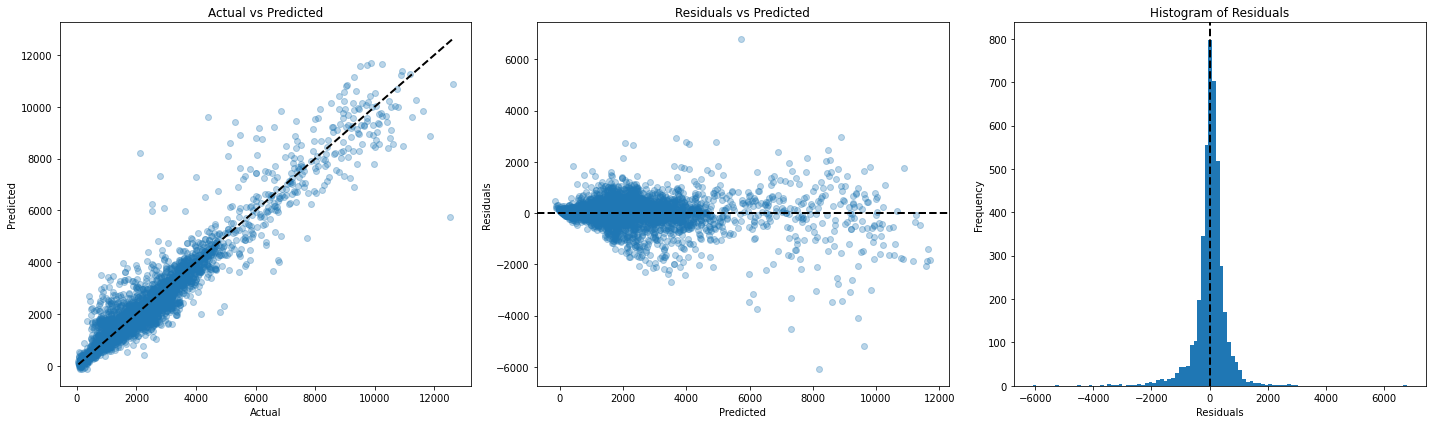

In [78]:
# evaluation visualisation
eval.evaluation_vis(y_daily_test, y_pred_2b)

In [79]:
print(eval.get_feature_importance(gb_daily, x_daily_train[feature_cols_daily]).to_string())

                                       Feature  Importance
38                     religion_buddhist_ratio     0.17135
21                           bike_docks_counts     0.13737
20                         bike_station_counts     0.10728
49                              health_1_ratio     0.10064
104                  start_borough_Westminster     0.08969
18                                day_of_month     0.08145
6                                      tempmax     0.06417
35                     ethnic_arab_other_ratio     0.03312
11                                      precip     0.01601
32              ethnic_african_caribbean_ratio     0.01409
10                                    humidity     0.01270
57                         crime_offences_rate     0.01264
75               residence_lengh_uk_born_ratio     0.01258
16                                     uvindex     0.01062
0                                  day_of_week     0.01061
19                                 day_of_year     0.009